# CAPM & Beta Calculation

The capital asset pricing model (CAPM) of William Sharpe (1964) and John Lintner (1965) marks the birth of asset pricing theory. The CAPM model gives prediction about the required rate of return of an asset that takes into account the asset's sensitivity to systematic risk(Beta) and the expected return of the market and the expected risk free rate.

The **Beta** is a measure of the sensitivity of an asset's return relative to a market benchmark rate of return.

$\beta=\frac{Cov(R_{i},R_{m})}{Var(R_{m}}=\rho_{m,i} \times \frac{\sigma_{i}}{\sigma_{m}}$

Beta equas zero means that the asset invested has the same volatility with the market benchmark.

**CAPM Formula:**

$R_{i}=R_{f}+\beta (R_{m}-R_{f})$

where

$R_{f}$: risk-free rate;

$R_{m}$: market return (SP500);

$R_{i}$: required rate of return of a stock

In [1]:
import os 
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas_datareader import data as web
from pulp import *

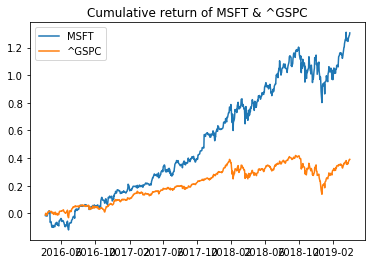

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     1181.
Date:                Thu, 04 Apr 2019   Prob (F-statistic):          2.34e-156
Time:                        02:07:03   Log-Likelihood:                 2516.3
No. Observations:                 755   AIC:                            -5029.
Df Residuals:                     753   BIC:                            -5019.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.779      0.0

In [35]:
class CAPM(object):
    def __init__(self,symbols,start,end):
        """
        :symbols:list
        :start:string, format "YYYY-MM-DD"
        :end:string, format "YYYY-MM-DD"
        
        """
        self.symbols=symbols+['^GSPC']
        self.start=dt.datetime.strptime(start, '%Y-%m-%d')
        self.end=dt.datetime.strptime(end, '%Y-%m-%d')
        
    def load_data(self):
        """
        data source: yahoo finance
        
        """
        df=pd.DataFrame()
        for i in self.symbols:
            name='./data/%s.csv'%i
            if not os.path.isfile(name):
                try:
                    temp= web.DataReader(i, 'yahoo', self.start, self.end)['Adj Close']
                except:
                    raise TypeError("Yahoo finance do not supply data of symbol %s. "%i)
            
                temp.to_frame().to_csv(name)
                df[i]=temp
            else:
                df[i]=pd.read_csv(name).set_index('Date')['Adj Close']
            
        df.columns=self.symbols
        df=df.pct_change()
        df=df.dropna()
        df.index=pd.to_datetime(df.index)
        
        self.daily_return=df
        self.acc_ret=(1 + self.daily_return).cumprod() - 1 
    
    def plot_cumret(self):
        """
        plot cumulative return
        
        """
        plt.plot(self.acc_ret)
        plt.title("Cumulative return of MSFT & ^GSPC")
        plt.legend(self.symbols)
        plt.show()
        
    def beta(self,sb=None):
        """        
        :sb:string, symbol specified
        :raises TypeError: if ``sb`` is not a string or sb is not in symbols list initiated
        
        """
        if sb!=None and sb in self.symbols and type(sb)==str:
            y=self.daily_return[sb]
        else:
            raise TypeError("Must specify only one symbol which is in the initial symbols list.")
            
        x=self.daily_return[self.symbols[-1]]

        #do OLS regression 
        X=sm.add_constant(x)
        res=sm.OLS(y,X).fit()
        return res

    def display_beta(self,sb=None):
        res=self.beta(sb)
        print(res.summary())
        
        
'''
--Download price data of Microsoft stock and SP500
--Data source: Yahoo Finance
--Start date: 04/03/2016
--End date: 04/03/2019

'''
obj=CAPM(['MSFT'],'2016-04-03','2019-04-03')
obj.load_data()
obj.plot_cumret()
obj.display_beta('MSFT')

The coefficient of ^GSPC is 1.37, which means the **beta** (3Y daily) of Microsoft is 1.37.

# Linear Programming: Portfolio Optimization

Modern portfolio optimization theory was pioneered by Harry Markowitz who introduced a method of allocating wealth optimally in assets with different risk and return sets.

To construct a linear programming problem, let the least absolute deviations as the objective funtion to minimize. 

Set constraints firstly the portfolio return larger than a target; secondly the beta equals 1.0 as specified; thirdly the sum of $x_{i}$ equals 1.0.Assume shortselling and taking leverage are allowed.

$ minimize \frac{1}{T}\sum_{t=1}^{T}|\sum_{i=1}^{n}x_{i}(R_{i}(t)-\frac{1}{T}\sum_{j=1}^{T}R_{i}(j))| $

s.t. $\frac{1}{T}\sum_{t=1}^{T}\sum_{i=1}^{n}x_{i}R_{i}(t) >=\mu$

$\beta=1.0$

$\sum_{i}^{n}x_{i}=1.0$




In [186]:
class PortfolioOpt(CAPM):
    def __init__(self, symbols,start,end,target_mu,target_beta=1.):
        super(PortfolioOpt,self).__init__(symbols,start,end)
        self.target_mu=target_mu
        self.target_beta=target_beta
        self.load_data()
     
    def portfolio(self,weight, mean_ret, cov):
        port_ret=np.sum(mean_ret*dec_vars_sort)
        port_std=np.sqrt(np.matrix(weight)*np.matrix(cov)*np.matrix(weight).T)[0,0]
        return port_ret,port_std
        
    def optimize(self):
        #load return data of all symbols except from benchmark rate
        ticker=self.symbols[:-1]
        df=self.daily_return[ticker]
        
        #calculate beta of all assets
        betas=[self.beta(k).params['^GSPC'] for k in ticker]
        
        #define decision variables
        list_dec_vars=list(range(len(self.symbols)-1))
        dec_vars=LpVariable.dicts("x",list_dec_vars,0.,1.)
        dec_vars_sort=[dec_vars[i] for i in range(len(dec_vars))]
        
        """define constraints"""
        #take the last item of accumulative return of each stock as the holding period return; annulized them using function: 
        #(1+Total return)^(252/days)-1
        annulized_holding_period_return=((1+self.acc_ret[ticker].iloc[-1])**(252./(len(self.acc_ret)+1))-1)
        c1=sum(( annulized_holding_period_return*dec_vars_sort))>=self.target_mu #portfolio annulized return larger than a target rate
        c2=sum(dec_vars_sort)==1 # sum of allocation weights equals 1.
        c3=sum([a*b for a,b in zip(betas,dec_vars_sort)])==self.target_beta  # portfolio's beta equals 1.
        
        #define objective function 
        problem=LpProblem("Portfolio Optimization", LpMinimize)
        
        #add constraint to the problem
        problem+=c1
        problem+=c2
        problem+=c3
        
        #add objective function to the problem
        problem+=((df-df.mean()).abs()*dec_vars_sort).sum(axis=1).sum(axis=0)/len(df)
        
        #solve the problem
        print(problem)
        problem.solve()
        allocate=[i.varValue for i in dec_vars_sort] 
        
        #calculate result
        annulized_return=((1+self.acc_ret[ticker].iloc[-1])**(252./(len(self.acc_ret)+1))-1)
        risk=((df-df.mean()).abs()*allocate).sum(axis=1).sum(axis=0)/len(df)
        portfolio_annulized_ret=sum([a*b for a,b in zip(annulized_return,allocate)])
        
        #return
        allocate_dict=dict(zip(self.symbols[:-1],[round(i,4) for i in allocate]))                         
        annulized_return_dict=dict(zip(self.symbols[:-1],[round(i,4) for i in annulized_return]))
        beta_dict=dict(zip(self.symbols[:-1],[round(i,4) for i in betas]))
        portfolio_return=round(sum([round(a*b,4) for a,b in zip(betas,allocate)]))
            
        return risk, round(portfolio_annulized_ret,4),allocate_dict,annulized_return_dict,beta_dict,portfolio_return

In [187]:
self=PortfolioOpt(['MSFT','AAPL','SBUX'],'2016-04-03','2019-04-03',0.1)
risk, portfolio_annulized_ret,allocate,annulized_ret,betas,beta=self.optimize()

Portfolio Optimization:
MINIMIZE
0.00939336388082*x_0 + 0.0102127007167*x_1 + 0.0082237721448*x_2 + 0.0
SUBJECT TO
_C1: 0.321166307642 x_0 + 0.227897509248 x_1 + 0.0934888456868 x_2 >= 0.1

_C2: x_0 + x_1 + x_2 = 1

_C3: 1.37156539199 x_0 + 1.24561294719 x_1 + 0.704409581257 x_2 = 1

VARIABLES
x_0 <= 1 Continuous
x_1 <= 1 Continuous
x_2 <= 1 Continuous



In [188]:
print('Annulized return of portfolio:',round(portfolio_annulized_ret,4))
print('Weights:',allocate)
print('Annulized return of each stock:',annulized_ret)
print('Beta of each stock:',betas)

('Annulized return of portfolio:', 0.1944)
('Weights:', {'SBUX': 0.5569, 'AAPL': 0.0, 'MSFT': 0.4431})
('Annulized return of each stock:', {'SBUX': 0.0935, 'AAPL': 0.2279, 'MSFT': 0.3212})
('Beta of each stock:', {'SBUX': 0.7044, 'AAPL': 1.2456, 'MSFT': 1.3716})
